### Import data

Variables:

    x_ij_hardcoded: list containing the current trade volume between countries
    c_ij: the current unitary cost of transporting petroleum from country A to country B
    c_ij_new: the updated unitary cost of transporting petroleum after the construction of the Kra canal
    supply: the total supply of petroleum for each country in countries
    demand: the total demand for petroleum for each country in countries
    keys_to_update: trade routes which will be reduced by the Kra canal construction
    canalreduc_km: the cost (in km) that will save in trade routes in keys_to_update


In [5]:
import csv


thresh_pen = .25



#initialize dictionaries
x_ij_hardcoded = {}

supply = {
}


demand = {
}

c_ij = {}

countries = ['AE', 'BR', 'IQ', 'US', 'KR', 'SA','IN','ES','TH','RU']
  
valid_country_pairs = [(i, j) for i in countries for j in countries if i != j]
for pair in valid_country_pairs:
    x_ij_hardcoded[pair] = 0

with open('/home/sam/Documents/Modelos en Redes/Data/volumesclenaed_crude.csv', 'r') as file:
    csv_reader = csv.DictReader(file)
    for row in csv_reader:
        key = (row['exporter'], row['importer'])
        x_ij_hardcoded[key] = float(row['quantity'])



with open('/home/sam/Documents/Modelos en Redes/Data/before_clean.csv', 'r') as file:
    csv_reader = csv.DictReader(file)
    
    for row in csv_reader:
        key = (row['Country1'], row['Country2'])
        c_ij[key] = float(row['Total.Cost'])



x_ij_hardcoded = {key: value / 1000000 for key, value in x_ij_hardcoded.items()}




for (exporter, importer), quantity in x_ij_hardcoded.items():
    if exporter in supply:
        supply[exporter] = supply.get(exporter, 0) + quantity
    else:
        supply[exporter] = quantity

    if importer in demand:
        demand[importer] = demand.get(importer, 0) + quantity
    else:
        demand[importer] = quantity  


if 'RU' not in demand:
    demand['RU'] = 0.0

#use big M to avoid countries trading with themselves 
for country in countries:
    c_ij[(country, country)] = 10000
    x_ij_hardcoded[(country, country)] = 0

#countries which will be updated
c_ij_new = c_ij.copy()
keys_to_update = [('ES', 'TH'), 
                  ('TH', 'IN'), 
                  ('TH', 'AE'), 
                  ('TH', 'IQ'),
                  ('KR', 'AE'), 
                  ('KR', 'SA'), 
                  ('KR', 'IQ'),
                  ('TH', 'ES'),
                  ('IN', 'TH'),
                  ('AE', 'TH'),
                  ('IQ', 'TH'),
                  ('AE', 'KR'),
                  ('AE', 'KR'),
                  ('SA', 'KR'),
                  ('IQ', 'KR'),
                  ('TH', 'SA'),
                  ('SA', 'TH'),
                  ('ES', 'KR'),
                  ('KR', 'ES')
                 ]

canalreduc_km = 300 
canalreduction = canalreduc_km /1.852

for key in keys_to_update:
    c_ij_new[key] = c_ij[key] - canalreduction * 0.001



## Estimate Unspecified Cost Parameters

In this section, the aim is to estimate some values of $t$ between each pair of countries. These costs represent additional factors that are extra barriers of trade between countries in addition to the distance measurements that we have already measured.

Keeping in mind the objective function of the model:

$$
\text{min} \quad Z = \sum_{i \in I} \sum_{j \in J} x_{ij} \cdot (c_{ij} + t_{ij}) \cdot p_{ij}
$$

and restriction for $p$:

$$
p_{ij} = \left(1.01\right)^{\max\left(0, \frac{x_{ij}}{\sum_{i \in I} x_{ij}} - \alpha\right) \times 100} \, \quad \forall i \in I, j \in J
$$

If we want to solve for values of parameter $t$ that result in the set values of variable $x$, given parameters $c$, then we must consider some feasibility problem that results in the generation of these values of $x$. The way I choose to estimate this is by adding a second objective function that is computed in parallel with the objective function $Z$ previously shown:

$$
\text{Squared Error} = \sum_{i=1}^{n} (x_{\text{original}, i} - x_{\text{predicted}, i})^2
$$

This function minimizes the squared error between the real world $x$ values and those predicted by my model. Note that this is simply MSE, without division by $n$, which would be unnecessary given that $n$ remains constant between the two sets.


In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pyomo.environ as pyo




model = pyo.ConcreteModel()

model.t = pyo.Var(countries, countries, within=pyo.NonNegativeReals)
model.x = pyo.Var(countries, countries, within=pyo.NonNegativeReals)
model.penalty = pyo.Var(countries, countries, within=pyo.NonNegativeReals)

def original_objective_function(model):
    return sum(model.x[i, j] * (model.t[i, j] + c_ij[i, j] * model.penalty[i, j])
               for i in countries for j in countries)

model.original_objective = pyo.Objective(rule=original_objective_function, sense=pyo.minimize)

def supply_rule(model, i):
    return sum(model.x[i, j] for j in countries) <= supply[i]

model.supply_constraints = pyo.Constraint(countries, rule=supply_rule)

def demand_rule(model, j):
    return sum(model.x[i, j] for i in countries) == demand[j]

model.demand_constraints = pyo.Constraint(countries, rule=demand_rule)


def penalty_constraint(model, i, j):
    if demand[j] > 0:

        proportion = model.x[i, j] / demand[j]
        penalty_expression = pyo.Expr_if(proportion > thresh_pen, 
                                         (1.01)**((proportion - thresh_pen) * 100), 
                                         1)
    else:
        penalty_expression = 100 

    return model.penalty[i, j] == penalty_expression

model.penalty_constraints = pyo.Constraint(countries, countries, rule=penalty_constraint)

model.original_objective.activate()
solver = pyo.SolverFactory('snopt', executable='/home/sam/Downloads/ampl_linux-intel64/snopt')
results = solver.solve(model)

model.original_objective.deactivate()
def discrepancy_objective(model):
    return sum((model.x[i, j] - x_ij_hardcoded[i, j])**2 for i in countries for j in countries)

model.discrepancy_objective = pyo.Objective(rule=discrepancy_objective, sense=pyo.minimize)
model.discrepancy_objective.activate()





results = solver.solve(model)

inferred_t_ij = { (i, j): model.t[i, j].value for i in countries for j in countries }



model.name="unknown";
    - termination condition: optimal
    - message from solver: SNOPT 7.5-1.2 \x3a Requested accuracy could not be
      achieved.; 396 iterations, objective 1346.6127125172459; Nonlin
      evals\x3a obj = 140, grad = 139, constrs = 140, Jac = 139.


## Model Validation

Next, using the estimated values of $t$ from the previous example, we re-calculated what the current optimal trade routes would be given our parameters. We can compare this to the true values and see by how far our model is off.

In [7]:

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pyomo.environ as pyo



t_ij = inferred_t_ij

G = nx.DiGraph()

for country in countries:
    G.add_node(country)

totalcost_before = {}

model = pyo.ConcreteModel()


model.x = pyo.Var(countries, countries, within=pyo.NonNegativeReals)

model.penalty = pyo.Var(countries, countries, within=pyo.NonNegativeReals)


def objective_function(model):
    total_cost = 0
    for i in countries:
        for j in countries:
            total_cost += model.x[i, j] * (t_ij[i, j] + c_ij[i, j] * model.penalty[i, j])

            totalcost_before[i] = total_cost
    return total_cost

model.objective = pyo.Objective(rule=objective_function, sense=pyo.minimize)



model.totalcost_canal = pyo.Var(countries, within=pyo.NonNegativeReals)
def total_cost_canal_rule(model, j):
    return model.totalcost_canal[j] == sum(
        model.x[i, j] * (t_ij[i, j] + c_ij[i, j] * model.penalty[i, j])
        for i in countries
    )

model.total_cost_canal_constraints = pyo.Constraint(countries, rule=total_cost_canal_rule)





def penalty_constraint(model, i, j):
    if demand[j] > 0:

        proportion = model.x[i, j] / demand[j]
        penalty_expression = pyo.Expr_if(proportion > thresh_pen, 
                                         (1.01)**((proportion - thresh_pen) * 100), 
                                         1)
    else:
        penalty_expression = 100 

    return model.penalty[i, j] == penalty_expression

model.penalty_constraints = pyo.Constraint(countries, countries, rule=penalty_constraint)

def supply_rule(model, i):
    return sum(model.x[i, j] for j in countries) == supply[i]

model.supply_constraints = pyo.Constraint(countries, rule=supply_rule)

def demand_rule(model, j):
    return sum(model.x[i, j] for i in countries) == demand[j]

model.demand_constraints = pyo.Constraint(countries, rule=demand_rule)


solver = pyo.SolverFactory('snopt', executable='/home/sam/Downloads/ampl_linux-intel64/snopt')


results = solver.solve(model, tee=True)


totalcost_before = {j: model.totalcost_canal[j].value for j in countries}


SNOPT 7.5-1.2 WARNING: Loading a SolverResults object with a warning status into
model.name="unknown";
    - termination condition: optimal
    - message from solver: SNOPT 7.5-1.2 \x3a Requested accuracy could not be
      achieved.; 402 iterations, objective 1346.4777018522518; Nonlin
      evals\x3a obj = 203, grad = 202, constrs = 203, Jac = 202.


With the solver status complete, and the parameter list t solved for, we can also extract the estimated a new value of x, or the total assigned volume of trade between each country. new_x represents the estimated current real-word trade volume given the solved t parameter, and will be compared against the true values used to estimated it.

In [8]:
new_x = { (i, j): model.x[i, j].value for i in countries for j in countries }

### Model Validation: Comparing the Model Against Real World Values

Now that we have model that is able to generate optimal route assignment, we compare them against the actual values in a number of ways:

The first two network maps show the flow volume (indiciated by line width) between countries, in both our predicted and actual data.

A bar chart allows these lines to be directly compared, but without the inaldirect interpretabilty of origin and destination points as the network maps.

Finally, the differene between the predicted and actual values for each trade route are predicted to directly pinpoint the greatest inaccuracies.

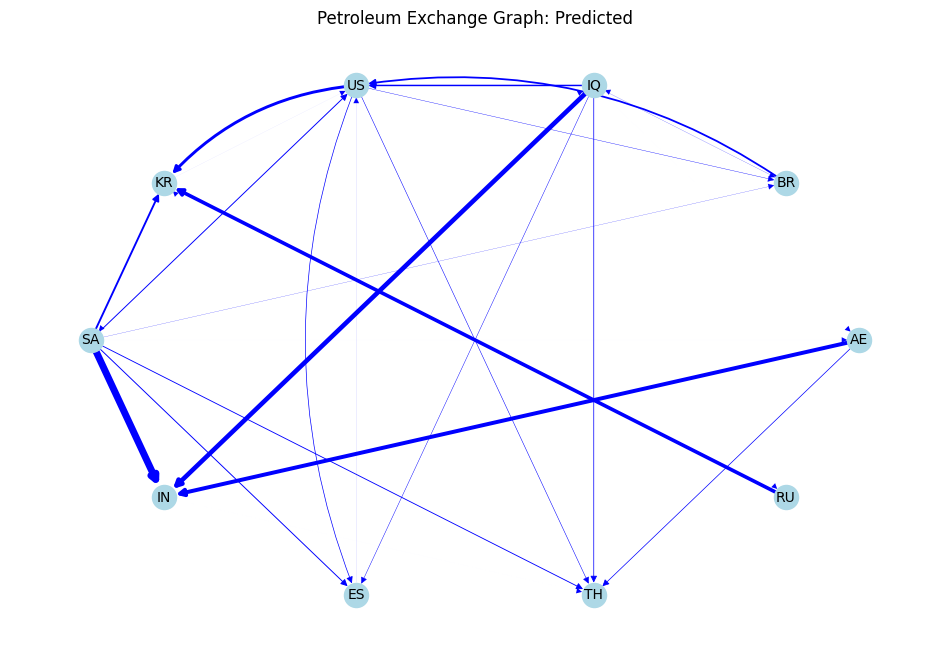

In [9]:

G_hardcoded = nx.DiGraph()
curved_edges = {}

def curved_edges(G, pos, arc_radius=0.2):
    curved_edges = {}
    for (u, v) in G.edges():
        if (v, u) in G.edges() and (v, u) not in curved_edges:
            middle = np.array([(pos[u][0] + pos[v][0]) / 2, (pos[u][1] + pos[v][1]) / 2])
            direction = np.array([pos[v][0] - pos[u][0], pos[v][1] - pos[u][1]])
            norm = np.sqrt(direction[0]**2 + direction[1]**2)
            direction = direction / norm
            perp_direction = np.array([-direction[1], direction[0]])
            curve_point = middle + arc_radius * perp_direction
            path = [pos[u], curve_point, pos[v]]
            curved_edges[(u, v)] = path
    return curved_edges
    
for country in countries:
    G_hardcoded.add_node(country)

for (i, j), flow in new_x.items():
    if i != j and flow > 0:
        G_hardcoded.add_edge(i, j, weight=flow)

angle = np.linspace(0, 2 * np.pi, len(countries), endpoint=False)
pos = {country: (np.cos(ang), np.sin(ang)) for country, ang in zip(countries, angle)}

max_weight = max(nx.get_edge_attributes(G_hardcoded, 'weight').values())
scale_factor = 5 / max_weight

curved_edge_paths = curved_edges(G_hardcoded, pos)

plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G_hardcoded, pos, node_color="lightblue")
nx.draw_networkx_labels(G_hardcoded, pos, font_size=10)

for (u, v), path in curved_edge_paths.items():
    nx.draw_networkx_edges(G_hardcoded, pos, edgelist=[(u, v)],
                           width=G_hardcoded[u][v]['weight'] * scale_factor,
                           edge_color='blue', connectionstyle=f"arc3,rad={0.2}")

straight_edges = [e for e in G_hardcoded.edges() if e not in curved_edge_paths]
nx.draw_networkx_edges(G_hardcoded, pos, edgelist=straight_edges, 
                       width=[G_hardcoded[u][v]['weight'] * scale_factor for u, v in straight_edges],
                       edge_color='blue')

plt.title("Petroleum Exchange Graph: Predicted")
plt.axis('off')
plt.show()



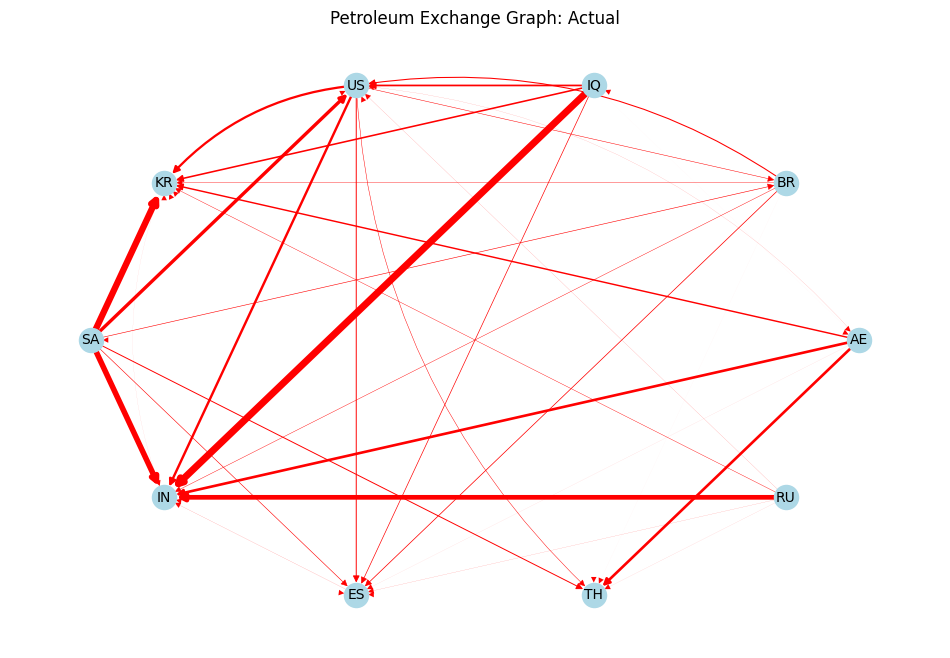

In [10]:
G_hardcoded = nx.DiGraph()
curved_edges = {}

def curved_edges(G, pos, arc_radius=0.2):
    curved_edges = {}
    for (u, v) in G.edges():
        if (v, u) in G.edges() and (v, u) not in curved_edges:
            middle = np.array([(pos[u][0] + pos[v][0]) / 2, (pos[u][1] + pos[v][1]) / 2])
            direction = np.array([pos[v][0] - pos[u][0], pos[v][1] - pos[u][1]])
            norm = np.sqrt(direction[0]**2 + direction[1]**2)
            direction = direction / norm
            perp_direction = np.array([-direction[1], direction[0]])
            curve_point = middle + arc_radius * perp_direction
            path = [pos[u], curve_point, pos[v]]
            curved_edges[(u, v)] = path
    return curved_edges
    
for country in countries:
    G_hardcoded.add_node(country)

for (i, j), flow in x_ij_hardcoded.items():
    if i != j and flow > 0:
        G_hardcoded.add_edge(i, j, weight=flow)

angle = np.linspace(0, 2 * np.pi, len(countries), endpoint=False)
pos = {country: (np.cos(ang), np.sin(ang)) for country, ang in zip(countries, angle)}

max_weight = max(nx.get_edge_attributes(G_hardcoded, 'weight').values())
scale_factor = 5 / max_weight

curved_edge_paths = curved_edges(G_hardcoded, pos)

plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G_hardcoded, pos, node_color="lightblue")
nx.draw_networkx_labels(G_hardcoded, pos, font_size=10)

for (u, v), path in curved_edge_paths.items():
    nx.draw_networkx_edges(G_hardcoded, pos, edgelist=[(u, v)],
                           width=G_hardcoded[u][v]['weight'] * scale_factor,
                           edge_color='red', connectionstyle=f"arc3,rad={0.2}")

straight_edges = [e for e in G_hardcoded.edges() if e not in curved_edge_paths]
nx.draw_networkx_edges(G_hardcoded, pos, edgelist=straight_edges, 
                       width=[G_hardcoded[u][v]['weight'] * scale_factor for u, v in straight_edges],
                       edge_color='red')

plt.title("Petroleum Exchange Graph: Actual")
plt.axis('off')
plt.show()


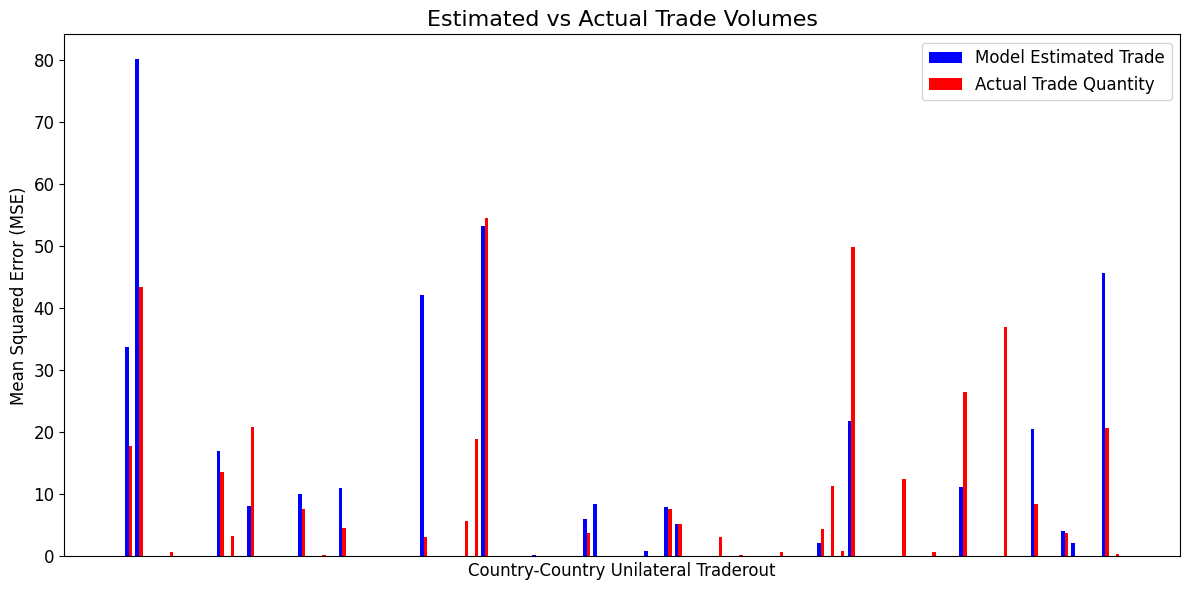

In [11]:
import numpy as np

country_pairs = list(set(new_x.keys()) | set(x_ij_hardcoded.keys()))

original_values_new_x = []
original_values_x_ij_hardcoded = []

for pair in country_pairs:
    original_values_new_x.append(new_x.get(pair, 0))
    original_values_x_ij_hardcoded.append(x_ij_hardcoded.get(pair, 0))

plt.figure(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(country_pairs))

plt.bar(index, original_values_new_x, bar_width, color='blue', label='Model Estimated Trade')
plt.bar(index + bar_width, original_values_x_ij_hardcoded, bar_width, color='red', label='Actual Trade Quantity')

plt.ylabel('Values')
plt.title('Estimated vs Actual Trade Volumes',fontsize=16)
plt.ylabel('Mean Squared Error (MSE)',fontsize=12)
plt.xlabel('Country-Country Unilateral Traderout',fontsize=12)
plt.xticks([]) 
plt.tick_params(axis='both', which='major', labelsize=12) 


plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


#### Differences in predicted and actual route assignment:

We can see overall, the models predictions aren't terribly far off. In the prediction of complex economic models such as this one, the accuracy of estimations are not just influenced by nuances beyond the capabilities of model predictors, but also the values of other predictions within the model. By looking at the residuals below, we see the net difference in volume for each trade route from the formula predicted - actual. We can observe some of the largest residuals: trade between Russia and India was greatly underestimated, and between Russia and Korea overestimated. These errors were likely due to the emphasis that maritime trade routes have in the model, and the fact that the domestic transport of petroleum inside a country is not considered is likely a source of inaccuricies involving large countries such as Russia, India, and the United States.

In [12]:
differences = {}

for pair in country_pairs:
    value_new_x = new_x.get(pair, 0)
    value_x_ij_hardcoded = x_ij_hardcoded.get(pair, 0)
    differences[pair] = value_new_x - value_x_ij_hardcoded

differences

{('ES', 'RU'): 0.0,
 ('US', 'KR'): 15.910553202255315,
 ('SA', 'IN'): 36.67337322280027,
 ('KR', 'KR'): 0.0,
 ('KR', 'SA'): 0.0,
 ('RU', 'ES'): -0.699221,
 ('IN', 'IQ'): 0.0,
 ('BR', 'IQ'): 0.0,
 ('IN', 'IN'): 0.0,
 ('US', 'US'): 0.0,
 ('IQ', 'US'): 3.430528892365979,
 ('BR', 'IN'): -3.2795009389999996,
 ('ES', 'KR'): -4e-08,
 ('AE', 'TH'): -12.715348281551613,
 ('AE', 'AE'): 0.0,
 ('ES', 'SA'): 0.0,
 ('TH', 'IQ'): 0.0,
 ('RU', 'RU'): -3.147252711705579e-18,
 ('SA', 'TH'): 2.4611674960817798,
 ('SA', 'AE'): 0.04868157641366986,
 ('AE', 'ES'): -0.312890044,
 ('TH', 'IN'): -5.6e-08,
 ('SA', 'ES'): 6.485818364883112,
 ('KR', 'BR'): 0.0,
 ('IN', 'TH'): 0.002810051,
 ('IN', 'AE'): 0.0,
 ('BR', 'TH'): -0.067936739,
 ('BR', 'AE'): 0.0,
 ('US', 'IQ'): 0.0,
 ('IQ', 'IQ'): 0.0,
 ('RU', 'KR'): 38.906036095,
 ('IN', 'ES'): -1.2999999999999999e-08,
 ('RU', 'SA'): 0.0,
 ('AE', 'RU'): 0.0,
 ('BR', 'ES'): -5.775038438,
 ('US', 'IN'): -18.907702279,
 ('IQ', 'IN'): -1.361597570799404,
 ('ES', 'BR'): 0.0

### Predicting Trade Assignment With Updated Costs

With the validation of the model and an understanding of its strengths and weakenesses, we can now use this model to predict trade volume using updated data. The values of $t$ that have been previously solved for will be used, as well as the $\alpha$ that was optimized in the other script. Finally, the cost data is updated to use c_ij_new, the cost dictionary created by subtracting the savings from the canal in affected trade routes. 

In [13]:
t_ij = inferred_t_ij




G = nx.DiGraph()

for country in countries:
    G.add_node(country)

model = pyo.ConcreteModel()


model.x = pyo.Var(countries, countries, within=pyo.NonNegativeReals)

model.penalty = pyo.Var(countries, countries, within=pyo.NonNegativeReals)


def objective_function(model):
    total_cost = 0
    for i in countries:
        for j in countries:
            total_cost += model.x[i, j] * (t_ij[i, j] + c_ij_new[i, j] * model.penalty[i, j])
    return total_cost

model.objective = pyo.Objective(rule=objective_function, sense=pyo.minimize)


model.totalcost_canal = pyo.Var(countries, within=pyo.NonNegativeReals)
def total_cost_canal_rule(model, j):
    return model.totalcost_canal[j] == sum(
        model.x[i, j] * (t_ij[i, j] + c_ij_new[i, j] * model.penalty[i, j])
        for i in countries
    )

model.total_cost_canal_constraints = pyo.Constraint(countries, rule=total_cost_canal_rule)


def penalty_constraint(model, i, j):
    if demand[j] > 0:

        proportion = model.x[i, j] / demand[j]
        penalty_expression = pyo.Expr_if(proportion > thresh_pen, 
                                         (1.01)**((proportion - thresh_pen) * 100), 
                                         1)
    else:
        penalty_expression = 100 

    return model.penalty[i, j] == penalty_expression

model.penalty_constraints = pyo.Constraint(countries, countries, rule=penalty_constraint)

def supply_rule(model, i):
    return sum(model.x[i, j] for j in countries) == supply[i]

model.supply_constraints = pyo.Constraint(countries, rule=supply_rule)

def demand_rule(model, j):
    return sum(model.x[i, j] for i in countries) == demand[j]

model.demand_constraints = pyo.Constraint(countries, rule=demand_rule)


solver = pyo.SolverFactory('snopt', executable='/home/sam/Downloads/ampl_linux-intel64/snopt')


results = solver.solve(model, tee=True)

totalcost_canal = {j: model.totalcost_canal[j].value for j in countries}
canal_x = { (i, j): model.x[i, j].value for i in countries for j in countries }


SNOPT 7.5-1.2 WARNING: Loading a SolverResults object with a warning status into
model.name="unknown";
    - termination condition: optimal
    - message from solver: SNOPT 7.5-1.2 \x3a Requested accuracy could not be
      achieved.; 365 iterations, objective 1338.4821287889474; Nonlin
      evals\x3a obj = 240, grad = 239, constrs = 240, Jac = 239.


Similarly to how we performed model validation, we can compare the trade route volume before and after the construction of the Kra canal. For consistency's sake, we will use the inferred $t$ values for the before volume, that is, using the models predicted current trade, and not the actual real-world data. This allows to focus on the variation caused by cost change, and not the variation caused by model bias.

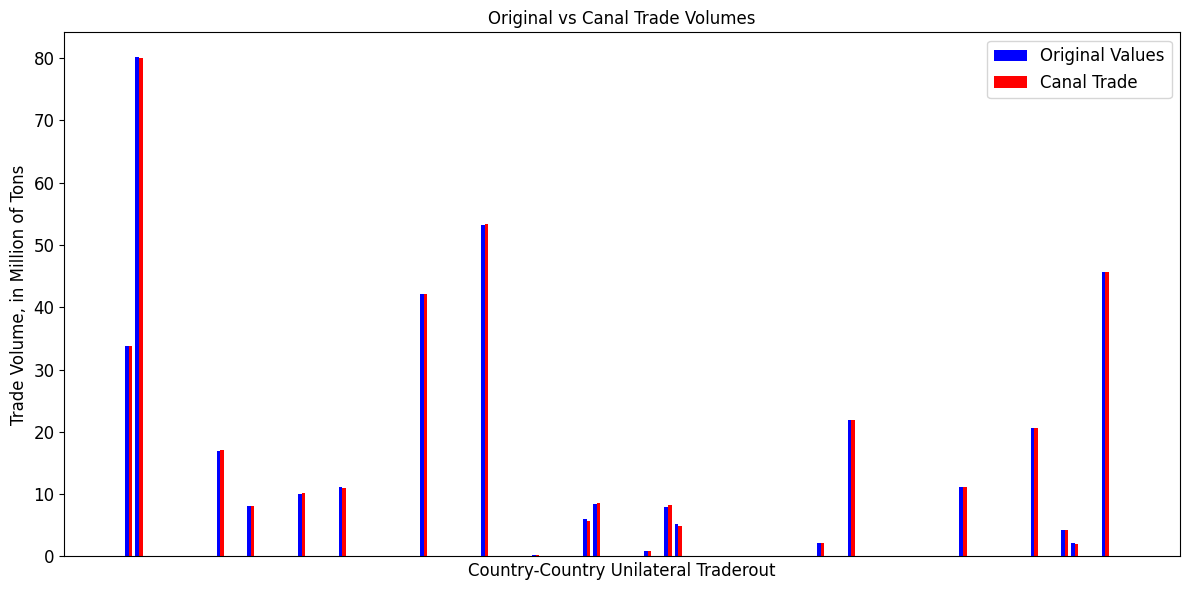

In [14]:
import numpy as np

country_pairs = list(set(new_x.keys()) | set(canal_x.keys()))

original_values_new_x = []
original_values_canal_x = []

for pair in country_pairs:
    original_values_new_x.append(new_x.get(pair, 0))
    original_values_canal_x.append(canal_x.get(pair, 0))

plt.figure(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(country_pairs))

plt.bar(index, original_values_new_x, bar_width, color='blue', label='Original Values')
plt.bar(index + bar_width, original_values_canal_x, bar_width, color='red', label='Canal Trade')

plt.ylabel('Trade Volume, in Million of Tons',fontsize=12)
plt.title('Original vs Canal Trade Volumes',fontsize=12)
plt.xlabel('Country-Country Unilateral Traderout',fontsize=12)
plt.xticks([]) 
plt.tick_params(axis='both', which='major', labelsize=12) 

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()


### Results

Unsurprisingly, the largest differencce in trade volume involved Thailand. Thailand saw a significant reduction in trade with the United States, as the new reduction in distance between Thailand and the Indian Ocean made Saudia Arabia a more viable trade partner for Thailand. This change is part of a ripple effect that impacted the other routes, resulting in changes such as more US-to-Spain imports, reduced Iraq-to-Spain imports, and more Iraq-to-Thailand imports.

In [15]:
def top_n_changes(new_x, canal_x, n=5):

    differences = [(key, canal_x[key] - new_x[key]) for key in new_x if key in canal_x]
    sorted_differences = sorted(differences, key=lambda x: abs(x[1]), reverse=True)
    return sorted_differences[:n]

changes = top_n_changes(new_x, canal_x, n=16)

print("Trade Routes with Significant Change:")
for key, change in changes:
    print(f"Key: {key}, Change: {change}")


Trade Routes with Significant Change:
Key: ('US', 'TH'), Change: -0.37370653671933773
Key: ('US', 'ES'), Change: 0.305535063716988
Key: ('IQ', 'ES'), Change: -0.28287351507797354
Key: ('SA', 'TH'), Change: 0.201481583395001
Key: ('IQ', 'TH'), Change: 0.17212488707983375
Key: ('IQ', 'IN'), Change: 0.16649646864590295
Key: ('SA', 'IN'), Change: -0.1663963879907584
Key: ('IQ', 'BR'), Change: -0.07760669531246123
Key: ('US', 'BR'), Change: 0.07760669531178532
Key: ('SA', 'ES'), Change: -0.02266154863901626
Key: ('SA', 'US'), Change: -0.021932088451167786
Key: ('IQ', 'US'), Change: 0.02193208845112693
Key: ('SA', 'KR'), Change: 0.009435313549843727
Key: ('US', 'KR'), Change: -0.009435313549779778
Key: ('AE', 'IN'), Change: -0.00010008065518007925
Key: ('AE', 'TH'), Change: 0.00010006624447278512


### Impact on Total Import Costs

By summing up all the trade route costs for individual importers, we can see how the changes brought about by the canal impact the total expenditures on petroleum import for specific countries. We see that, while countries like Thailand and Korea greatly benefit from closer access to the Indian Ocean and therefore the Persian Gulf, the savings aren't enjoyed by all countries. Some countries such as United Arab Emirates, US, and India, appear largely unimpacted. However, the total petroleum import costs in Spain and Brazil have increased quite a bit.

In [16]:
importers = ['AE','BR','KR','IN','ES','TH','US']

differences = {j: 100*(totalcost_canal[j] - totalcost_before[j])/totalcost_before[j] for j in importers}

for j, difference in differences.items():
    print(f"Country {j}: Difference = {difference}")

Country AE: Difference = 0.07163854363057086
Country BR: Difference = 0.2338651135480856
Country KR: Difference = -0.9933495510399344
Country IN: Difference = -0.018581277299617397
Country ES: Difference = 0.5366186697874027
Country TH: Difference = -3.028522548458967
Country US: Difference = -0.0018532671384704836


### Sensitivity Analysis

Although most literature suggests that the construction of a canal would reduce transport distance by 1200 km, it's hard to say for certain how this will impact costs. Because the model generates cost partially as a function of distance, this results in a $1200c_{ij}$ reduction in transport cost for any country benefiting from the canal. It's important to note that there are other costs and benefits associated with a canal, and that this $1200c_{ij}$ cannot be guaranteed. For this reason, performing a sensitivity analysis can verify the robustness of the model to different amounts of savings caused by the canal.The following graph shows the percent change in total petroleum import costs for each country as a function of canal savings in the domain $[0, 1750c_{ij}]$.

Interestingly enough, the most probable cost reduction of $1200c_{ij}$ doesn't appear to be a very optimal point in savings. The cost difference in many countries actually see a local maximum here, and even countries that benefit most from the canal such as Thailand would be better off if the canal brought less in savings. For the most part, it seems like a canal that either reduces more or less savings would be ideal for the global economy.

Although there are many more considerations to consider in the modelling of a global petroleum economy, the delicate relationship between global trade routes is demonstrated clearly in this model. Although there are many possible economic and environmental advantages of reducing trade route distance, it's important to understand the ripple effects they might cause. This involves investigating potential hazards in unexpected places, such as the potential risks of reducing too much distance from a trade route.

That said, the construction of a Kra canal shows strong potential to save resources not just in petroleum trade, but in all economic sectors as the push for renewable energy continues. The necessity of optimizing trade routes will not disappear alongside fossil fuels, but will grow in importance, and the advance of economic modelling technology will be an essential tool in the process.

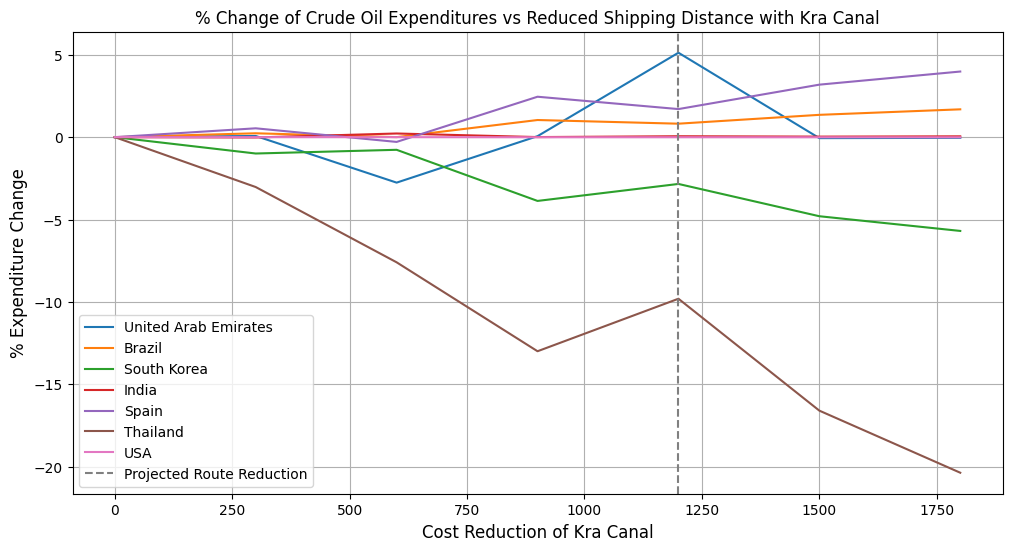

In [17]:
import pandas as pd
import matplotlib.pyplot as plt


canalsavings = {
    "distance": [0, 300, 600, 900, 1200, 1500, 1800],
    "United Arab Emirates": [0, 0.07163854363057086, -2.761187129520391, 0.05971653518851704, 5.1253934208442, -0.06015290001400642, -0.041549456332116014],
    "Brazil": [0, 0.2338651135480856, 0.00048474256586618456, 1.0399356357572234, 0.8170220996921617, 1.3544121004063385, 1.6889491311153753],
    "South Korea": [0, -0.9933495510399344, -0.7683314476369029, -3.872074783599574, -2.8411589543718616, -4.8012384671995685, -5.693644275094147],
    "India": [0, -0.018581277299617397, 0.22130585642925363, 0.004587353486356176, 0.05492769959185901, 0.03223840175336278, 0.04934488798489572],
    "Spain": [0, 0.5366186697874027, -0.28953843698273457, 2.4537705992148005, 1.7041333273616472, 3.186907796169159, 3.983303842038912],
    "Thailand": [0, -3.028522548458967, -7.598603526767112, -12.99818468348773, -9.810143900525352, -16.603889827150567, -20.372875638691728],
    "USA": [0, -0.0018532671384704836, -2.773113483350027e-06, -0.0067168844163776106, -0.0057235883504034085, -0.008075549855796697, -0.009423372298618117]
}


df = pd.DataFrame(canalsavings)


plt.figure(figsize=(12, 6))
for country in df.columns[1:]: 
    plt.plot(df['distance'], df[country], label=country)

plt.title("% Change of Crude Oil Expenditures vs Reduced Shipping Distance with Kra Canal")
plt.axvline(x=1200, color='gray', linestyle='--', label='Projected Route Reduction')
plt.xlabel("Cost Reduction of Kra Canal",fontsize=12)
plt.ylabel("% Expenditure Change",fontsize=12)
plt.legend()
plt.grid(True)
plt.show()
